In [1]:
import sys
sys.path.append('../util')
sys.path.append('../experiments')

import os
# Disable weights and biases (if installed)
os.environ["WANDB_DISABLED"] = "true"
os.environ["TOKENIZERS_PARALLELISM"] = "false"
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
from pathlib import Path
import re
import logging
from convert_annotations import read_webanno, webanno_to_iob_df, join_and_resolve, EMPTY_REGEX, VALUE_REGEX, log
import pandas as pd
import transformers, datasets
from transformers import AutoModelForTokenClassification, AutoTokenizer, Trainer, TrainingArguments, pipeline, DataCollatorForTokenClassification, EarlyStoppingCallback, trainer_utils
from huggingface_utils import load_custom_dataset, LabelAligner, compute_metrics, eval_on_test_set
from run_experiment import get_train_args
import hydra
from hydra import compose, initialize

datasets.logging.set_verbosity_error()
transformers.logging.disable_default_handler()
log.setLevel(logging.ERROR)

## Error Analysis

### Load the best model for the span length / granularity settings and the corresponding dataset

In [3]:
def load_pipeline_and_data(setting):
    cfg_file = f'{setting}.yaml'
    model_checkpoint = f'../data/models/huggingface/{setting}/'

    hydra.core.global_hydra.GlobalHydra.instance().clear()
    initialize(config_path=Path('..') / 'experiments')
    config = compose(config_name=cfg_file, overrides=['cuda=0', 'link=false'])
    
    tokenizer = AutoTokenizer.from_pretrained(config['base_model_checkpoint'])
    
    dataset, tags = load_custom_dataset(train=config['train_dataset'], dev=config['dev_dataset'], test=config['test_dataset'], tag_strings=config['task'])
    
    assert isinstance(tokenizer, transformers.PreTrainedTokenizerFast)
    
    label_aligner = LabelAligner(tokenizer)
    dataset = dataset.map(lambda e: label_aligner.tokenize_and_align_labels(e, config['label_all_tokens']), batched=True)
    
    training_args = get_train_args(cp_path='../ner_results', run_name='error_analysis', report_to=[], **config, resume_from_checkpoint=model_checkpoint)
    
    model = AutoModelForTokenClassification.from_pretrained(
        model_checkpoint
    )

    data_collator = DataCollatorForTokenClassification(tokenizer)
    tr = Trainer(
        args=training_args,
        model=model,
        train_dataset=dataset["train"],
        eval_dataset=dataset["dev"],
        data_collator=data_collator,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics(tags, True),
    )
    
    return tr, model, dataset["test"], tokenizer

In [4]:
tr_short, model_short, test_ds_short, tokenizer = load_pipeline_and_data('02_ggponc_fine_short')
tr_long, model_long, test_ds_long, _ = load_pipeline_and_data('04_ggponc_fine_long')

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/59515 [00:00<?, ?ex/s]

  0%|          | 0/12770 [00:00<?, ?ex/s]

  0%|          | 0/13714 [00:00<?, ?ex/s]

  0%|          | 0/6 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/60 [00:00<?, ?ba/s]

  0%|          | 0/13 [00:00<?, ?ba/s]

  0%|          | 0/14 [00:00<?, ?ba/s]

INFO:run_experiment:error_analysis


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?ba/s]

  0%|          | 0/13 [00:00<?, ?ba/s]

  0%|          | 0/14 [00:00<?, ?ba/s]

INFO:run_experiment:error_analysis


In [5]:
from transformers.pipelines.token_classification import AggregationStrategy
pipe_short = pipeline("ner", model_short, tokenizer=tokenizer, device=0, aggregation_strategy=AggregationStrategy.FIRST)
pipe_long = pipeline("ner", model_long, tokenizer=tokenizer, device=0, aggregation_strategy=AggregationStrategy.FIRST)

### Look at predictions on a few example sentences

In [6]:
wiki_sentence = """"Cetuximab ist ein monoklonaler Antikörper, der gegen den epidermalen Wachstumsfaktorrezeptor (EGFR) gerichtet ist und 
dient zur Therapie des fortgeschrittenen kolorektalen Karzinoms zusammen mit Irinotecan oder in Kombination mit FOLFOX bzw. 
allein nach Versagen einer Behandlung mit Oxaliplatin und Irinotecan."""

In [7]:
pipe_short(wiki_sentence)

[{'entity_group': 'Clinical_Drug',
  'score': 0.962233,
  'word': 'Cetuximab',
  'start': 1,
  'end': 10},
 {'entity_group': 'Clinical_Drug',
  'score': 0.9626528,
  'word': 'Antikörper',
  'start': 32,
  'end': 42},
 {'entity_group': 'Nutrient_or_Body_Substance',
  'score': 0.9637979,
  'word': 'Wachstumsfaktorrezeptor',
  'start': 70,
  'end': 93},
 {'entity_group': 'Nutrient_or_Body_Substance',
  'score': 0.9641919,
  'word': 'EGFR',
  'start': 95,
  'end': 99},
 {'entity_group': 'Therapeutic',
  'score': 0.9628338,
  'word': 'Therapie',
  'start': 130,
  'end': 138},
 {'entity_group': 'Diagnosis_or_Pathology',
  'score': 0.9629651,
  'word': 'Karzinoms',
  'start': 174,
  'end': 183},
 {'entity_group': 'Clinical_Drug',
  'score': 0.9623752,
  'word': 'Irinotecan',
  'start': 197,
  'end': 207},
 {'entity_group': 'Therapeutic',
  'score': 0.9629323,
  'word': 'FOLFOX',
  'start': 232,
  'end': 238},
 {'entity_group': 'Diagnosis_or_Pathology',
  'score': 0.96274424,
  'word': 'Versag

In [8]:
pipe_long(wiki_sentence)

[{'entity_group': 'Clinical_Drug',
  'score': 0.92421424,
  'word': 'Cetuximab',
  'start': 1,
  'end': 10},
 {'entity_group': 'Clinical_Drug',
  'score': 0.9235098,
  'word': 'monoklonaler Antikörper',
  'start': 19,
  'end': 42},
 {'entity_group': 'Nutrient_or_Body_Substance',
  'score': 0.92463005,
  'word': 'epidermalen Wachstumsfaktorrezeptor',
  'start': 58,
  'end': 93},
 {'entity_group': 'Nutrient_or_Body_Substance',
  'score': 0.9239702,
  'word': 'EGFR',
  'start': 95,
  'end': 99},
 {'entity_group': 'Therapeutic',
  'score': 0.92163867,
  'word': 'Therapie des fortgeschrittenen kolorektalen Karzinoms',
  'start': 130,
  'end': 183},
 {'entity_group': 'Clinical_Drug',
  'score': 0.9246952,
  'word': 'Irinotecan',
  'start': 197,
  'end': 207},
 {'entity_group': 'Therapeutic',
  'score': 0.9218072,
  'word': 'FOLFOX',
  'start': 232,
  'end': 238},
 {'entity_group': 'Diagnosis_or_Pathology',
  'score': 0.9211978,
  'word': 'Versagen einer Behandlung mit Oxaliplatin und Irinote

In [9]:
guideline_sentence = """Als Alternative empfiehlt die ASCCP bei zytologischem Verdacht auf CIN 1/2 die sofortige Kolposkopie."""

In [10]:
pipe_short(guideline_sentence)

[{'entity_group': 'Other_Finding',
  'score': 0.96294,
  'word': 'Verdacht',
  'start': 54,
  'end': 62},
 {'entity_group': 'Diagnosis_or_Pathology',
  'score': 0.96257114,
  'word': 'CIN',
  'start': 67,
  'end': 70},
 {'entity_group': 'Diagnostic',
  'score': 0.9636781,
  'word': 'Kolposkopie',
  'start': 89,
  'end': 100}]

In [11]:
pipe_long(guideline_sentence)

[{'entity_group': 'Other_Finding',
  'score': 0.9217645,
  'word': 'zytologischem Verdacht auf CIN 1 / 2',
  'start': 40,
  'end': 74},
 {'entity_group': 'Diagnostic',
  'score': 0.9219378,
  'word': 'sofortige Kolposkopie',
  'start': 79,
  'end': 100}]

In [12]:
clinical_note_sentence  = """Antibiose fortsetzen (s. o.), Abstrich erfragen, ggf. Umstellung der Antibiose. Thromboseprophylaxe bis zur sicheren Mobilität."""

In [13]:
pipe_short(clinical_note_sentence)

[{'entity_group': 'Therapeutic',
  'score': 0.96311814,
  'word': 'Antibiose',
  'start': 0,
  'end': 9},
 {'entity_group': 'Therapeutic',
  'score': 0.96376956,
  'word': 'Umstellung',
  'start': 54,
  'end': 64},
 {'entity_group': 'Therapeutic',
  'score': 0.96073705,
  'word': 'Antibiose',
  'start': 69,
  'end': 78},
 {'entity_group': 'Therapeutic',
  'score': 0.9622617,
  'word': 'Thromboseprophylaxe',
  'start': 80,
  'end': 99},
 {'entity_group': 'Other_Finding',
  'score': 0.96310234,
  'word': 'Mobilität',
  'start': 117,
  'end': 126}]

In [14]:
pipe_long(clinical_note_sentence)

[{'entity_group': 'Therapeutic',
  'score': 0.92327774,
  'word': 'Antibiose',
  'start': 0,
  'end': 9},
 {'entity_group': 'Diagnostic',
  'score': 0.9229312,
  'word': 'Abstrich',
  'start': 30,
  'end': 38},
 {'entity_group': 'Therapeutic',
  'score': 0.9218672,
  'word': 'Umstellung der Antibiose',
  'start': 54,
  'end': 78},
 {'entity_group': 'Therapeutic',
  'score': 0.9218916,
  'word': 'Thromboseprophylaxe',
  'start': 80,
  'end': 99},
 {'entity_group': 'Other_Finding',
  'score': 0.9219573,
  'word': 'sicheren Mobilität',
  'start': 108,
  'end': 126}]

#### Get metrics and error analysis on test set

In [15]:
test_set_metrics_short = eval_on_test_set(test_ds_short, tr_short, tokenizer, "test_short_full")
test_set_metrics_long = eval_on_test_set(test_ds_long, tr_long, tokenizer, "test_long_full")

13714it [00:05, 2575.51it/s]


13714it [00:05, 2585.25it/s]


In [16]:
test_set_metrics_long

{'test_long_full/boundary_error': 2684,
 'test_long_full/false_negative': 1695,
 'test_long_full/false_positive': 1849,
 'test_long_full/label_boundary_error': 1830,
 'test_long_full/labeling_error': 1521,
 'test_long_full/true_positive': 22894,
 'test_long_full/loss': 0.9115415811538696,
 'test_long_full/Clinical_Drug_precision': 0.707409155261916,
 'test_long_full/Clinical_Drug_recall': 0.7555443548387096,
 'test_long_full/Clinical_Drug_f1': 0.7306848647331221,
 'test_long_full/Clinical_Drug_number': 1984,
 'test_long_full/Diagnosis_or_Pathology_precision': 0.7566739173422978,
 'test_long_full/Diagnosis_or_Pathology_recall': 0.7842795654847304,
 'test_long_full/Diagnosis_or_Pathology_f1': 0.7702294685990339,
 'test_long_full/Diagnosis_or_Pathology_number': 9758,
 'test_long_full/Diagnostic_precision': 0.6845344960246217,
 'test_long_full/Diagnostic_recall': 0.7385168788046486,
 'test_long_full/Diagnostic_f1': 0.7105017968853985,
 'test_long_full/Diagnostic_number': 3614,
 'test_long_

# Coordination ellipses

Annotators were asked to annotate ellipses and their corresponding resolution using the `prefix` and `suffix` items as well as `fragment` relations for morpheme coordination (i.e., omission of subwords, in German commonly indicated by a Auslassungsstrich "-")

In [17]:
# Unzip webanno raw annotations
!unzip -q -n -d ../data/annotations/webannoo ../data/annotations/webanno.zip
!ls ../data/annotations/webanno | wc -l

10193


#### Read the raw data from WebAnno TSV files

In [18]:
%%time
tsv_folder = '../data/annotations/webanno'

webanno_df, _ = read_webanno(Path(tsv_folder).glob('*.tsv'))

CPU times: user 35 s, sys: 1.08 s, total: 36.1 s
Wall time: 46.1 s


In [19]:
%%time

import warnings

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    iob_df = webanno_to_iob_df(webanno_df, 'detail', True, debug=False, collect_errors=False, skip_errors=True, all_columns=True)
    iob_df['id'] = iob_df.entity_id.where(~iob_df.entity_id.isna(), iob_df.spec_id)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 85999/85999 [49:24<00:00, 29.01it/s]


CPU times: user 49min 39s, sys: 22.7 s, total: 50min 1s
Wall time: 49min 55s


In [20]:
# Anything containing a prefix, suffix or fragment is potentially an elliptical construct
ellipses = iob_df[~iob_df.prefix.str.match(EMPTY_REGEX) | ~iob_df.suffix.str.match(EMPTY_REGEX) | ~iob_df.fragment.str.match(EMPTY_REGEX)].copy()

### Resolve ellipses and connect fragment parts

In [21]:
%%time
results = []
for _, r in ellipses.id.reset_index().drop_duplicates().iterrows():
    has_fragment = False
    idx = r.file, r.sentence_id
    _id = r.id
    sentence = ellipses.loc[idx]
    span = sentence[sentence.id == _id]
    full_sentence = iob_df.loc[idx]
    full_span = full_sentence[full_sentence.id == _id]
    for fragment in span.fragment: # Expand span to fragments
        if fragment and not re.match(EMPTY_REGEX, fragment):
            has_fragment = True
            fragment = re.split('[|;]', fragment)[0]
            m = re.match(VALUE_REGEX, fragment)
            if not m:
                print(span.fragment)
            fragment_index = int(m.group(1).split('-')[1])
            fragment_start = min(fragment_index, full_span.token_id.min())
            fragment_end = max(fragment_index, full_span.token_id.max())
            full_span = full_sentence[(full_sentence.token_id >= fragment_start) & (full_sentence.token_id <= fragment_end)]
            expanded_context = full_sentence[full_sentence.id.isin(full_span.id.dropna().unique())].token_id
            fragment_start = min(fragment_start, expanded_context.min())
            fragment_end = max(fragment_end, expanded_context.max())
            full_span = full_sentence[(full_sentence.token_id >= fragment_start) & (full_sentence.token_id <= fragment_end)]
    fragment, resolution, missing_prefix, missing_suffix = join_and_resolve(full_span)
    results.append({
        'file' : idx[0],
        'sentence_id' : idx[1],
        'full_sentence' : list(full_sentence.token),
        'span_index_start': full_span.token_id.min() - 1,
        'span_index_end' : full_span.token_id.max() - 1,
        'full_span' : fragment,
        'resolution' : resolution,
        'fragment' : has_fragment,
        'missing_prefix' : missing_prefix,
        'missing_suffix' : missing_suffix,
    })
results = pd.DataFrame(results)

<timed exec>:6: PerformanceWarning: indexing past lexsort depth may impact performance.
<timed exec>:8: PerformanceWarning: indexing past lexsort depth may impact performance.


CPU times: user 3min 43s, sys: 1.37 s, total: 3min 44s
Wall time: 3min 45s


### Statistics

In [22]:
ellipses_sentence_count = len(results[['file', 'sentence_id']].drop_duplicates())
sentence_count = 78090
ellipses_sentence_count, sentence_count, ellipses_sentence_count / sentence_count

(4666, 78090, 0.05975156870277885)

In [23]:
print('Ellipses', len(results))
print('Forward ellipses', len(results[results.missing_prefix & ~results.missing_suffix]), len(results[results.fragment & results.missing_prefix & ~results.missing_suffix]))
print('Backward ellipses', len(results[~results.missing_prefix & results.missing_suffix]), len(results[results.fragment & ~results.missing_prefix & results.missing_suffix]))
print('Complex ellipses', len(results[results.missing_prefix & results.missing_suffix]), len(results[results.fragment & results.missing_prefix & results.missing_suffix]))

Ellipses 5264
Forward ellipses 1964 844
Backward ellipses 2979 2739
Complex ellipses 282 199


### Browsing random examples and their resolution

In [24]:
import random

def show_random(df):
    i = random.randint(0, len(df))
    item = df.iloc[i]    
    assert len(item.full_span) == len(item.resolution)
    spans = []
    solutions = []
    marker = []
    for span, res in zip(item.full_span, item.resolution):
        if span == res:
            marker.append(' ' * len(span))
        else:
            marker.append('^' * len(res))
        start_index = res.find(span)
        spans.append(span.rjust(start_index + len(span)).ljust(len(res) - start_index))
        solutions.append(res)
    print(' '.join(spans))
    print(' '.join(solutions))
    print(' '.join(marker))
    print(item.file, item.sentence_id, 'fragment:', item.fragment)
    print('...........')
    print('')

Examples with fragment attribute (typically elliptical compounds)

In [25]:
for _ in range(0, 10):
    show_random(results[results.fragment])

Lymph         - und Gefäßinvasion
Lymphinvasion - und Gefäßinvasion
^^^^^^^^^^^^^                    
21_hodentumoren_0194.tsv 2 fragment: True
...........

signifikant besseres 1                 - und 2 - Jahresüberleben
signifikant besseres 1-Jahresüberleben - und 2 - Jahresüberleben
                     ^^^^^^^^^^^^^^^^^                          
03_lungenkarzinom_0391.tsv 29 fragment: True
...........

en-bloc - und R0 - Resektionsraten
en-bloc - und R0 - Resektionsraten
                                  
01_magenkarzinom_0073.tsv 27 fragment: True
...........

stationären und ambulanten Versorgungs          - und Therapieangeboten
stationären und ambulanten Versorgungsangeboten - und Therapieangeboten
                           ^^^^^^^^^^^^^^^^^^^^                        
26_palliativmedizin_0089.tsv 5 fragment: True
...........

Gefühl der Selbstverantwortung und -           kontrolle
Gefühl der Selbstverantwortung und - der Selbstkontrolle
                                     ^^

Examples without fragment attribute (often omitted prepositions)

In [26]:
for _ in range(0, 10):
    show_random(results[~results.fragment])

Prognosefaktor für die lokale Tumorkontrolle ,     das rezidivfreie Überleben , und     das Gesamtüberleben
Prognosefaktor für die lokale Tumorkontrolle , für das rezidivfreie Überleben , und für das Gesamtüberleben
                                               ^^^^^^^                              ^^^^^^^                
29_adulte-weichgewebesarkome_0124.tsv 2 fragment: False
...........

im Bindungsstil begründete Ängste vor Ablehnung und     Abhängigkeit
im Bindungsstil begründete Ängste vor Ablehnung und vor Abhängigkeit
                                                    ^^^^^^^^^^^^^^^^
26_palliativmedizin_0606.tsv 14 fragment: False
...........

Verlängerung des progressionsfreien Überlebens und des Gesamtüberlebens bei geringer Toxizität und     guter Lebensqualität
Verlängerung des progressionsfreien Überlebens und des Gesamtüberlebens bei geringer Toxizität und bei guter Lebensqualität
                                                                                           

### Evaluation of NER models on these instances

In [27]:
idx = set(results.set_index(['file', 'sentence_id']).index.unique().values)
idx_frag = set(results[results.fragment].set_index(['file', 'sentence_id']).index.unique().values)

In [28]:
test_ds_short_ellipsis = test_ds_short.filter(lambda item: (item['fname'], item['sentence_id']) in idx)
test_ds_short_fragment = test_ds_short.filter(lambda item: (item['fname'], item['sentence_id']) in idx_frag)
test_ds_long_ellipsis = test_ds_long.filter(lambda item: (item['fname'], item['sentence_id']) in idx)
test_ds_long_fragment = test_ds_long.filter(lambda item: (item['fname'], item['sentence_id']) in idx_frag)

  0%|          | 0/14 [00:00<?, ?ba/s]

  0%|          | 0/14 [00:00<?, ?ba/s]

  0%|          | 0/14 [00:00<?, ?ba/s]

  0%|          | 0/14 [00:00<?, ?ba/s]

In [29]:
test_set_metrics_short_ellipses = eval_on_test_set(test_ds_short_ellipsis, tr_short, tokenizer, "test_short_ellipsis")
test_set_metrics_short_fragment = eval_on_test_set(test_ds_short_fragment, tr_short, tokenizer, "test_short_fragment")
test_set_metrics_long_ellipses = eval_on_test_set(test_ds_long_ellipsis, tr_long, tokenizer, "test_long_ellipsis")
test_set_metrics_long_fragment = eval_on_test_set(test_ds_long_fragment, tr_long, tokenizer, "test_long_fragment")

740it [00:00, 1867.93it/s]
542it [00:00, 1926.76it/s]
740it [00:00, 1821.35it/s]
542it [00:00, 1887.95it/s]


In [30]:
error_cols = ['false_negative', 'false_positive', 'labeling_error', 'boundary_error', 'label_boundary_error']

In [31]:
def get_dataframe(metrics):
    count = 0
    for k, v in metrics.items():
        if '_number' in k:
            count += v
    data = {}
    key = None
    for k_long, v in metrics.items():
        subset, k = tuple(k_long.split('/'))
        assert not key or key == subset
        key = subset
        if k in error_cols + ['true_positive']:
            data[f"{k}_abs"] = v
            data[f"{k}"] = v / count
        if k == 'overall_f1':
            data[k] = v
    data['subset'] = subset
    return pd.DataFrame([data]).set_index('subset')

In [32]:
stats = pd.concat([
    get_dataframe(test_set_metrics_short),
    get_dataframe(test_set_metrics_short_ellipses),
    get_dataframe(test_set_metrics_short_fragment),
    get_dataframe(test_set_metrics_long),
    get_dataframe(test_set_metrics_long_ellipses),
    get_dataframe(test_set_metrics_long_fragment),
])

In [33]:
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import cm

In [34]:
matplotlib.rcParams.update({'font.size': 16})

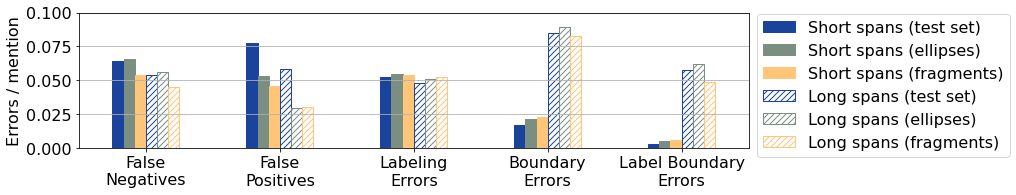

In [38]:
ax = plt.figure(figsize=(12,2.5)).add_subplot(111)

stats[error_cols].T.rename(
    {
        'false_negative' : 'False\nNegatives',
        'false_positive' : 'False\nPositives',
        'labeling_error' : 'Labeling\nErrors',
        'boundary_error' : 'Boundary\nErrors',
        'label_boundary_error' : 'Label Boundary\nErrors',
    }).rename({
        'test_short_full' : 'Short spans (test set)',
        'test_short_ellipsis' : 'Short spans (ellipses)',
        'test_short_fragment' : 'Short spans (fragments)',
        'test_long_full' : 'Long spans (test set)',
        'test_long_ellipsis' : 'Long spans (ellipses)',
        'test_long_fragment' : 'Long spans (fragments)'
    }, axis=1
    ).plot.bar(rot=0, ax=ax
)

ax.grid(axis='y')

c1, c2, c3 = '#19439c', '#7a8e82', '#ffc67a'

bars = ax.patches
hatches = [None] * 15 + ['////'] * 15
colors = ([c1] * 5 + [c2] * 5 + [c3] * 5) * 3

for bar, hatch, color in zip(bars, hatches, colors):
    if not hatch:
        bar.set_color(color)
    else:
        bar.set_color('white')
    bar.set_edgecolor(color)
    bar.set_hatch(hatch)

    
ax.set_ylabel('Errors / mention')
    
plt.legend(bbox_to_anchor=(1.0, 1.05))
plt.ylim([0.0,0.1])

plt.savefig('error_analysis.png', dpi=600, bbox_inches="tight")

plt.show()

### Manual inspection

In [39]:
pipe_long('Krebs-Vorsorge / -Früherkennung')

[{'entity_group': 'Diagnostic',
  'score': 0.896983,
  'word': 'Krebs',
  'start': 0,
  'end': 5},
 {'entity_group': 'Diagnostic',
  'score': 0.50938445,
  'word': 'Vorsorge',
  'start': 6,
  'end': 14},
 {'entity_group': 'Diagnostic',
  'score': 0.9128919,
  'word': 'Früherkennung',
  'start': 18,
  'end': 31}]

In [40]:
pipe_long('HPV31, 33, 45 und 51')

[{'entity_group': 'Diagnosis_or_Pathology',
  'score': 0.92164946,
  'word': 'HPV31, 33, 45 und 51',
  'start': 0,
  'end': 20}]

In [41]:
pipe_long('Vitamin C, E und A1')

[{'entity_group': 'Nutrient_or_Body_Substance',
  'score': 0.92097646,
  'word': 'Vitamin C',
  'start': 0,
  'end': 9},
 {'entity_group': 'Nutrient_or_Body_Substance',
  'score': 0.91745543,
  'word': 'E',
  'start': 11,
  'end': 12},
 {'entity_group': 'Nutrient_or_Body_Substance',
  'score': 0.8318585,
  'word': 'A1',
  'start': 17,
  'end': 19}]

In [42]:
pipe_long('Chemo- und Strahlentherapie')

[{'entity_group': 'Therapeutic',
  'score': 0.9219,
  'word': 'Chemo',
  'start': 0,
  'end': 5},
 {'entity_group': 'Therapeutic',
  'score': 0.9225101,
  'word': 'Strahlentherapie',
  'start': 11,
  'end': 27}]

In [43]:
pipe_long('BRAF- und MEK-Inhibitor')

[{'entity_group': 'Clinical_Drug',
  'score': 0.92278975,
  'word': 'BRAF',
  'start': 0,
  'end': 4},
 {'entity_group': 'Clinical_Drug',
  'score': 0.92444754,
  'word': 'MEK - Inhibitor',
  'start': 10,
  'end': 23}]

In [44]:
pipe_long('zielgerichtete und Immuntherapien')

[{'entity_group': 'Therapeutic',
  'score': 0.6532479,
  'word': 'zielgerichtete',
  'start': 0,
  'end': 14},
 {'entity_group': 'Therapeutic',
  'score': 0.91695094,
  'word': 'Immuntherapien',
  'start': 19,
  'end': 33}]

In [45]:
pipe_long('HPV-16- und/oder -18-Positivität')

[{'entity_group': 'Diagnosis_or_Pathology',
  'score': 0.918407,
  'word': 'HPV - 16',
  'start': 0,
  'end': 6},
 {'entity_group': 'Diagnosis_or_Pathology',
  'score': 0.9107298,
  'word': '18 - Positivität',
  'start': 18,
  'end': 32}]

In [46]:
pipe_long('BRCA1/2-Mutation')

/home/Florian.Borchert/miniconda3/envs/ggponc/lib/python3.8/site-packages/transformers/pipelines/base.py:908: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


[{'entity_group': 'Diagnosis_or_Pathology',
  'score': 0.92019343,
  'word': 'BRCA1',
  'start': 0,
  'end': 5},
 {'entity_group': 'Diagnosis_or_Pathology',
  'score': 0.8651293,
  'word': '2 - Mutation',
  'start': 6,
  'end': 16}]

In [47]:
pipe_long('Zweitlinien- oder Drittliniensystem- bzw. -chemotherapie')

[{'entity_group': 'Therapeutic',
  'score': 0.92089695,
  'word': 'Zweitlinien',
  'start': 0,
  'end': 11},
 {'entity_group': 'Therapeutic',
  'score': 0.9220769,
  'word': 'Drittliniensystem',
  'start': 18,
  'end': 35},
 {'entity_group': 'Therapeutic',
  'score': 0.92307276,
  'word': 'chemotherapie',
  'start': 43,
  'end': 56}]